# Data Exploration Notebook

<img src="header/de_header.jpg"  width="400"/>

---

*The following information was taken from the UCI Machine Learning Repository*. The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The data is split into a train (75%) a test (25%) partition and stored in two .tsv files. The data sets both have the following features:
1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful



**Citation Requested by UCI**: Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.


#### Import Libraries

In [ ]:
!pip3 install --upgrade tensorflow

In [ ]:
!pip install seaborn --upgrade # update from 0.10.0 to 0.11.1

In [ ]:
pip install -U sagemaker # update sagemaker

In [ ]:
pip install tdqm

In [ ]:
# Import General Libraries
import numpy as np
import pandas as pd
import time
import tqdm
import os
import platform
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow Libraries
import tensorflow as tf

# Import SKLearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Import SageMaker Libraries
import sagemaker
from sagemaker.tensorflow import TensorFlow, TensorFlowModel

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
sns.set_palette(palette=sns.color_palette("viridis", 10))
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'

# Check Versions
print(f'TensorFlow Version: {tf.__version__}') # == 2.4.1
print(f'SageMaker Version: {sagemaker.__version__}') # == 2.35+
print(f'Python Version: {platform.python_version()}') # == 3.6.0+
print(f'Seaborn Version: {sns.__version__}') # == 0.11.1+

## Data Loading & Exploration
We want to read in data from the UCI archive directly since we are using SageMaker. For convenience, we will extract the files and move them into a new subdirectory, as well as deleting the original zip file.

In [3]:
def download_and_format():
    '''
    Download the data from UCI, remove the zip, create subdirectory for data, and 
    move files into the subdirectory. Function will return two dataframes (train, test).
    '''
    data_dir = 'data'
    if not os.path.exists(data_dir):
        !wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
        !unzip -o drugsCom_raw.zip
        os.remove('drugsCom_raw.zip')
        os.mkdir(data_dir)
        Path('drugsComTrain_raw.tsv').rename(data_dir + '/drugsComTrain_raw.tsv')
        Path('drugsComTest_raw.tsv').rename(data_dir + '/drugsComTest_raw.tsv')
    train_data = pd.read_csv(data_dir + '/drugsComTrain_raw.tsv', sep = '\t')
    test_data = pd.read_csv(data_dir + '/drugsComTest_raw.tsv', sep = '\t')
    return train_data, test_data

train, test = download_and_format()

In [4]:
train.drop('Unnamed: 0', axis=1, inplace=True) # unique id (not needed for exploration)
train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
len(train) # original length

161297

In [6]:
train.describe().T # values are as expected

,count,mean,std,min,25%,50%,75%,max
rating,161297.0,6.994377,3.272329,1.0,5.0,8.0,10.0,10.0
usefulCount,161297.0,28.004755,36.403742,0.0,6.0,16.0,36.0,1291.0


### Drop Missing and Unrelated Values

In my exploration, I found that condition was missing 899 values, which will not be an issue for the model since the condition will not be used. But for the data exploration we will want to drop these missing values since we will want to look into the condition feature. I also noticed that some conditions simply said how many people found a review useful. Again, this won't be an issue in the modeling part, but for exploration we will want to drop these values as well.

In [7]:
train.isna().sum()

drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [8]:
train = train[train.condition.notna()].reset_index()

In [9]:
train[train.condition.str.contains('</span>')].head()

,index,drugName,condition,review,rating,date,usefulCount
104,105,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3.0,"November 3, 2010",2
194,196,Provera,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p...",1.0,"March 27, 2016",4
241,243,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3.0,"June 1, 2010",3
262,264,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2.0,"June 24, 2014",4
389,391,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9.0,"March 15, 2009",11


In [10]:
idx_drop = train[train.condition.str.contains('</span>')].index.values

In [11]:
train.drop(train.index[idx_drop], inplace=True)

In [12]:
train[train.condition.str.contains('</span>')] # no values found

,index,drugName,condition,review,rating,date,usefulCount


In [13]:
len(train)

159498

After dropping the missing values and unrelated conditions, we dropped 1799 values in total. This won't have too large of an effect since we still have around 160,000 observations that are fully complete in our dataset.

## Numerical Exploration
Two features we want to further explore in our data is `rating` and `usefulCount`. We will want to see the ratings and usefulCount distribution. We will also want to evaluate the `usefulCount` column to see if it can be related to the rating column to determine the validity of the reviews.

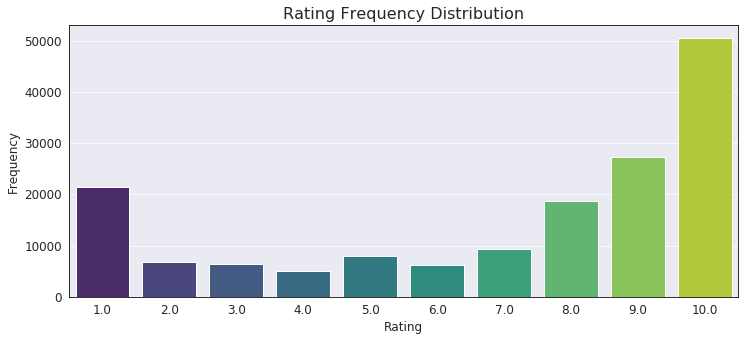

In [14]:
plt.figure(figsize=(12,5))
sns.countplot(x='rating', data=train)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Frequency Distribution')
plt.show();

There seems to be a majority of the reviews on the positive side (7-10) compared to the neutral (4-6) or negative (1-3) sides. This could lead to a class imbalance is we use the rating column as our labels (seperated into 3 categories), so we may want to account for `usefulCount` when creating our class labels (but this will be taken care of later on).

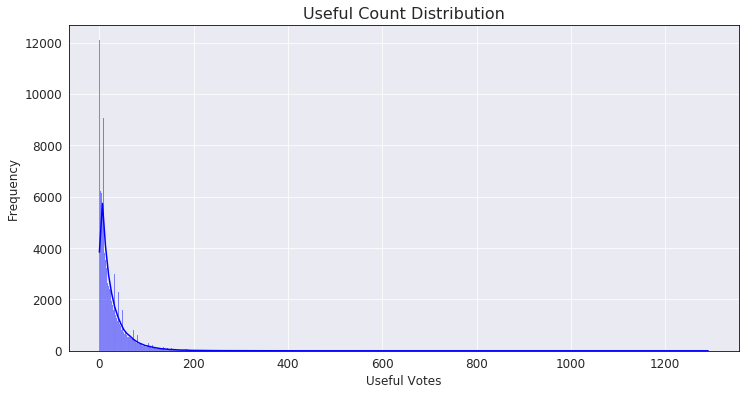

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(x='usefulCount', data=train, kde=True, color='blue')
plt.xlabel('Useful Votes')
plt.ylabel('Frequency')
plt.title('Useful Count Distribution')
plt.show();

In [16]:
np.percentile(train.usefulCount, 99) # 99% of the data is below 167 votes

167.0

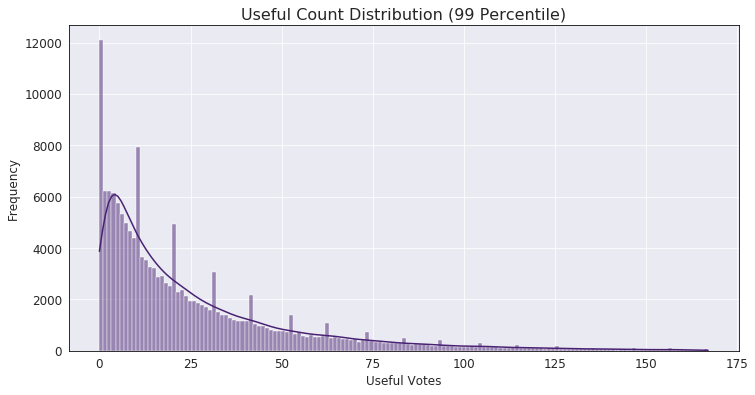

In [17]:
subset_99 = train[train.usefulCount <= 167]
plt.figure(figsize=(12,6))
sns.histplot(x='usefulCount', data=subset_99, kde=True)
plt.xlabel('Useful Votes')
plt.ylabel('Frequency')
plt.title('Useful Count Distribution (99 Percentile)')
plt.show();

We seem to have an extreme right skew in the `usefulCount` feature. The 99 percentile was 167, and even the graph for this subset of values had a right skew. Although the usefulCount value does not effect our rating, it could be considered in the validity of the review. But with extreme values over the 99% percentile we need to be careful to not allow them to effect the sentiment value if we decide to use it.

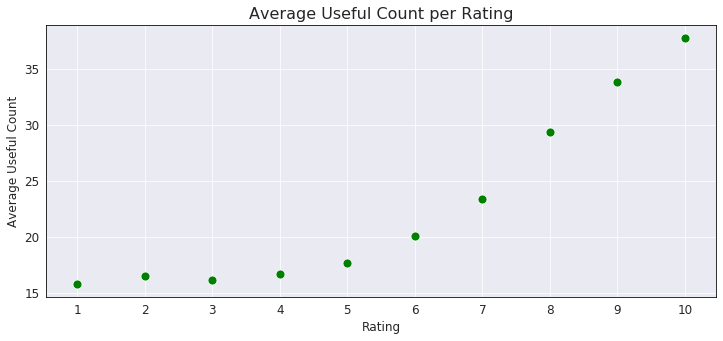

In [18]:
rate_useful = train.groupby('rating').agg('sum').usefulCount / train.groupby('rating').agg('count')['index']
plt.figure(figsize=(12,5))
sns.scatterplot(x=rate_useful.index, y=rate_useful.values, s=80, color='green')
plt.xlabel('Rating')
plt.xticks(np.arange(1,11))
plt.ylabel('Average Useful Count')
plt.title('Average Useful Count per Rating')
plt.show();

It seems that the average `usefulCount` votes increases as the rating increases. This could be an indicator that the positive reviews could be more reliable than the negative reviews, or just a fact that people seemed to have less negative effects and therefore did not vote for a negative review. We will want to keep this in mind when creating our data in the modeling notebook (is the rating given truely reliable?).

## Categorical Exploration

Three of the categorical features we will want to explore are `condition`, `drugName`, and `date`. We won't go to far into depth for the `reviews` feature since this will be done in the modeling notebook. We will want to look at the top 10 most common conditions (as well as the top 10 drugs administered for the top condition), the top 10 most common drugs and their use cases, and a distribution of the dates (yearly and monthly).

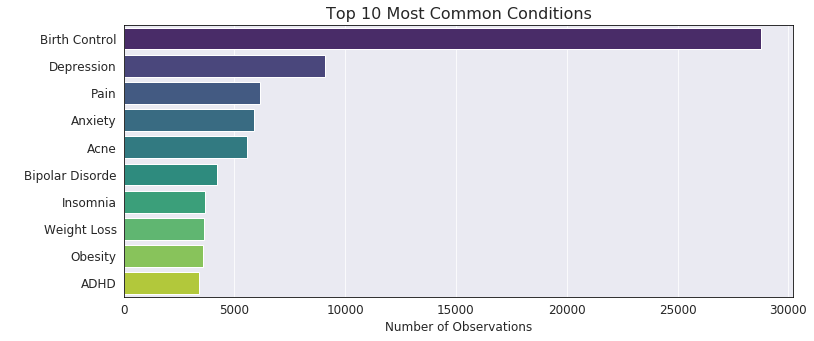

In [19]:
top10_condition = train.groupby('condition').agg('count').sort_values(by ='drugName', ascending=False)[:10]

plt.figure(figsize=(12,5))
sns.barplot(y=top10_condition['index'].index, x=top10_condition['index'].values)
plt.xlabel('Number of Observations')
plt.ylabel(' ')
plt.title('Top 10 Most Common Conditions')
plt.show();

Birth control seems to be the most common condition by at least 3x, followed by Depression and Pain. These conditions related to perscription drugs are expected and there was no suprises in the findings. We may want to look at the distribution of `drugName` for Birth control to better understand the observations.

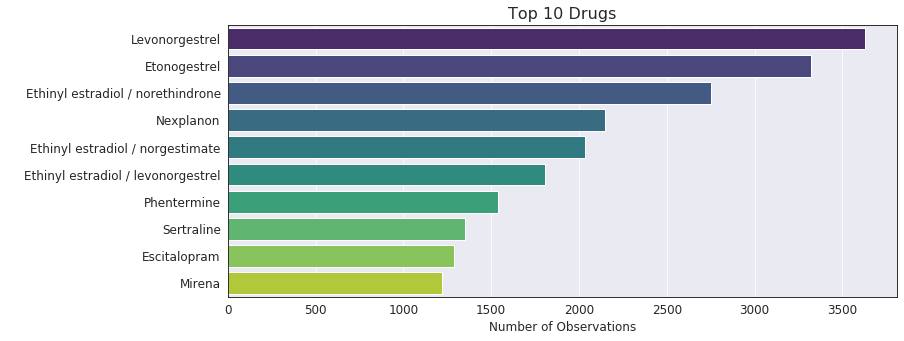

In [20]:
top_drugs = train.groupby('drugName').agg('count').sort_values(by ='review', ascending=False)[:10]
plt.figure(figsize=(12,5))
sns.barplot(y=top_drugs['index'].index, x=top_drugs['index'].values)
plt.xlabel('Number of Observations')
plt.ylabel(' ')
plt.title('Top 10 Drugs')
plt.show();

In [21]:
train[train.drugName == 'Levonorgestrel'].groupby('condition').agg('count').sort_values(by ='review', 
                                                                                        ascending=False)['index']

condition
Birth Control                2129
Emergency Contraception      1221
Abnormal Uterine Bleeding     276
Not Listed / Othe               5
Name: index, dtype: int64

In [22]:
len(train.drugName.unique())

3412

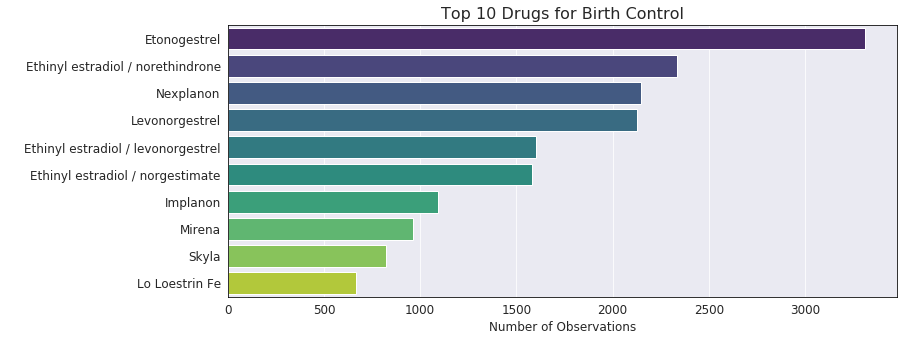

In [23]:
bc_drugs = train[train.condition == 'Birth Control'].groupby('drugName').agg('count').sort_values(by ='review', 
                                                                                                  ascending=False)[:10]
plt.figure(figsize=(12,5))
sns.barplot(y=bc_drugs['index'].index, x=bc_drugs['index'].values)
plt.xlabel('Number of Observations')
plt.ylabel(' ')
plt.title('Top 10 Drugs for Birth Control')
plt.show();

Of the 3412 unique drugs it seems that the top 6 most common all relate to birth control. On top of this, 7 of the top 10 all relate to birth control. It was expected that the top condition (by 3x) would have the highest occuring drugs in the dataset.

In [41]:
train['date'] = pd.to_datetime(train.date)
train['year'] = train['date'].dt.year

In [42]:
train.head()

,index,drugName,condition,review,rating,date,usefulCount,year
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,2012
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,2010
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,2009
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,2015
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,2016


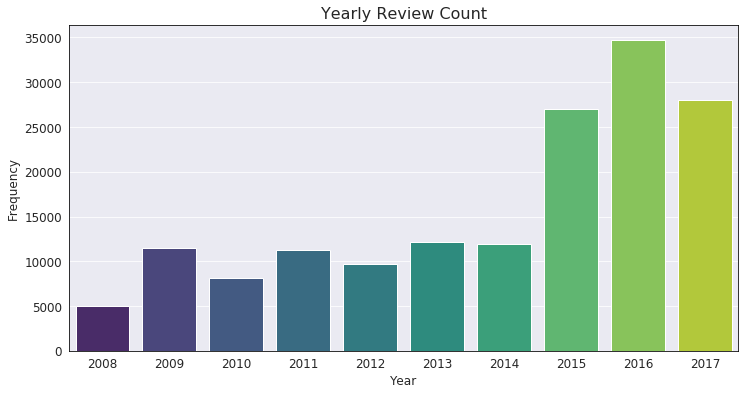

In [52]:
plt.figure(figsize=(12,6))
sns.countplot(x='year', data=train)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Yearly Review Count')
plt.show();

It seems that the last 3 years in the dataset (2015-2017) hold the majority of the reviews. It seemed to be steady from 2009-2014, and then more than doubling in 2015-2017. We may want to look into what caused this spike, or what the average review is each year to see if more reviews leads to a higher average?

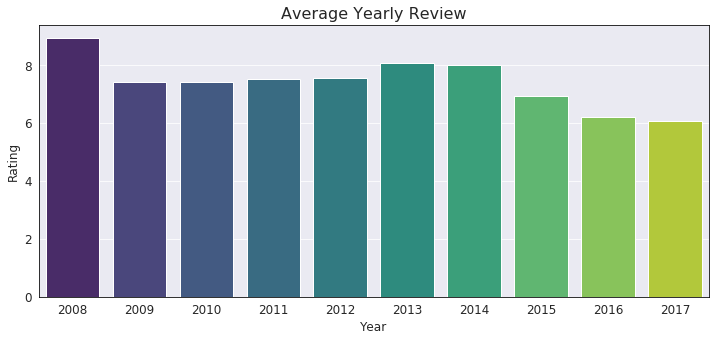

In [67]:
yearly_rating = train.groupby('year').agg('sum')['rating'] / train.groupby('year').agg('count')['date']

plt.figure(figsize=(12,5))
sns.barplot(x = yearly_rating.index, y = yearly_rating.values)
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Yearly Review')
plt.show();

It does not seem that the reviews were increasing as more were recorded, rather the opposite. For 2008, it had the lowest number of total reviews yet it had the highest average. For 2016, it had the highest total reviews yet it had almost the lowest average rating (very close to 2017 which had the lowest). This could mean that more reviews could correlate to more negative reviews?